In [2]:
import pylab
import numpy as np
import itertools
import matplotlib
import cPickle as pickle
import itertools 
%matplotlib inline
pylab.rcParams['figure.figsize'] = (24, 18)

from map_vie import Individual

In [10]:
type([]) is list

True

In [50]:
def get_fitness(value):
    if type(value) is list :
        return value[0].fitness
    else:
        return value.fitness

def make_fitness_map(qd_map) :
    return {key : get_fitness(qd_map[key]) for key in qd_map}

def plot_map(fitness_map, dimensions, layout, bounds=None, ax=None, aspect=None) :
    # dimensions should be a list/tuple of the number of possibilities for each dimensio
    # layout should be length 2 list where layout[0] is a list of the dimensions put on the rows, in their order of nesting
    # (inner to outer), similar for layout[1] (for the columns)
    # bounds should be tuple (min,max) for scaling color bar or None to use data min and max
    # ax should be a subplot axis instance or None
    # aspect should be aspect ratio for imshow or None
    
    num_rows = np.product([dimensions[i] for i in layout[0]])
    num_cols = np.product([dimensions[i] for i in layout[1]])
    assert( num_rows * num_cols == np.product(dimensions) )
    
    to_plot = np.zeros((num_rows, num_cols))

    tmp = [1] + [dimensions[j] for j in layout[0]]
    row_scaling = [np.product(tmp[:j]) for j in range(1,len(tmp))]        
    tmp = [1] + [dimensions[j] for j in layout[1]]
    col_scaling = [np.product(tmp[:j]) for j in range(1,len(tmp))]        
    
    qd_score = 0
    
    if bounds is None :
        max_fitness = np.max([fitness_map[key] for key in fitness_map])
    else :
        max_fitness = -1 * bounds[0]
    
    
    for key in itertools.product(*[range(i) for i in dimensions]):
        row = np.dot([key[j] for j in layout[0]], row_scaling)
        col = np.dot([key[j] for j in layout[1]], col_scaling)
        
        if key in fitness_map :
            to_plot[row, col] = -1 * fitness_map[key]
            qd_score += (max_fitness - fitness_map[key]) / max_fitness
        else :
            to_plot[row, col] = 1
            
    if bounds is None :
        norm = matplotlib.colors.Normalize(vmin=np.min(to_plot[to_plot <= 0]), vmax=np.max(to_plot))
    else : 
        norm = matplotlib.colors.Normalize(vmin=bounds[0], vmax=bounds[1])
    m = pylab.cm.ScalarMappable(norm=norm, cmap="YlOrRd")


    empty_mask = to_plot == 1
    violated_mask = to_plot == -10000
    to_plot = m.to_rgba(to_plot)
    to_plot[empty_mask] = [1.0, 1.0, 1.0, 1.0]
    to_plot[violated_mask] = [0.0, 0.0, 0.0, 1.0]

    m.set_array(to_plot)

    if ax == 'none' :
        return qd_score
    
    if ax is None :
        ax = pylab.subplot(1,1,1)

    ax.imshow(to_plot, interpolation="none", origin="upper", aspect=aspect)
    ax.tick_params(axis='both', which='both',length=0)
    
    ax.set_title(str(qd_score))

    # x3
    #xticks = [i*9 + 4.5 for i in range(5)]
    #xticklabels = map(str, range(5))
    # num motors
    #xticks += range(40)
    #xticklabels += [str((i%8)+1) for i in range(40)]

    #ax.set_xticks(xticks)
    #ax.set_xticklabels(xticklabels)
    #for i, t in enumerate(ax.get_xticklabels()) :
    #    t.set_y( -0.05 if i < 5 else 0 )

    # rolling
    #yticks = [9.5, 29.5]
    #yticklabels = ['No', 'Yes']
    #yticks += range(40)
    #yticklabels += [str((i%20)+1) for i in range(40)]
    #ax.set_yticks(yticks)
    #ax.set_yticklabels(yticklabels)
    #for i, t in enumerate(ax.get_yticklabels()) :
    #    t.set_x( -0.05 if i < 2 else 0 )

    #ax.set_xlabel("Num Light Sensors (Num Motors)", fontsize=18)
    #ax.set_ylabel("Rolling (Num Blocks)", fontsize=18)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    pylab.colorbar(m)
    
    lw = 2
    for a in row_scaling[1:] :
        ax.hlines([(i+1)*a-0.5 for i in range(num_rows/a)], -0.5, num_cols - 0.5, lw=lw)
        lw += 2
    lw = 2
    for a in col_scaling[1:] :
        ax.vlines([(i+1)*a-0.5 for i in range(num_cols/a)], -0.5, num_rows - 0.5, lw=lw)
        lw += 2
       

    #best_key = min(performance_map, key=lambda k: performance_map[k][0].fitness)
    #np.savetxt("best_guy_full_trajectory_1.txt",performance_map[best_key][0].genome[None,:])
    return qd_score

    
#performance_map = pickle.load(open("results/full_trajectory_5_mins_"+str(1)+ ".pickle"))
#plot_map(make_fitness_map(performance_map), (3,3,3,3,3,3), [[1, 3, 5], [0, 2, 4]])


   
import os    
def playback(performance_map):
    np.savetxt("request.txt", np.vstack((performance_map[key].genome for key in performance_map)))
    os.system("cd Java2dRobotSim && ./runApplet.sh config/config2d.txt . ../request.txt 1")


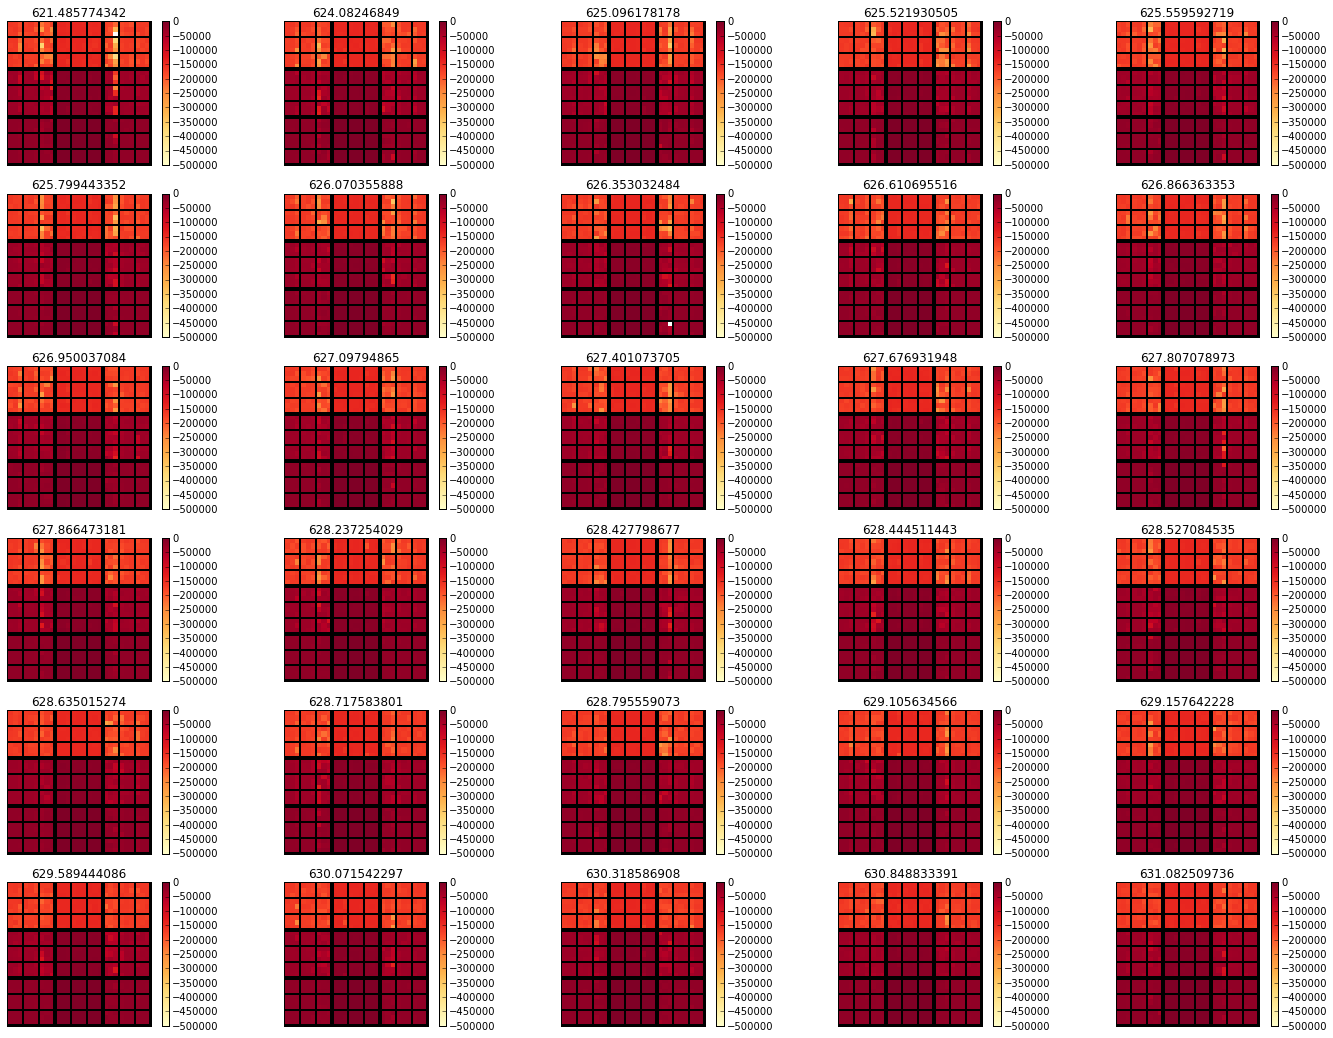

In [25]:
performance_maps = [pickle.load(open("results/full_trajectory_5_mins_"+str(seed)+"/qd_map.pickle")) for seed in range(1,31)]
#performance_maps = [pickle.load(open("results/init_results/full_trajectory_5_mins_"+str(seed)+".pickle")) for seed in range(1,31)]

performance_maps.sort(key=lambda x: plot_map(make_fitness_map(x), (3,3,3,3,3,3), [[1, 3, 5], [0, 2, 4]], 
                      ax='none', bounds=(-500000,0)))

map_elites_qd_scores = np.zeros(30)
for i, performance_map in enumerate(performance_maps):
    map_elites_qd_scores[i] = plot_map(make_fitness_map(performance_map), (3,3,3,3,3,3), [[1, 3, 5], [0, 2, 4]], 
                      ax=pylab.subplot(6,5,i+1), bounds=(-500000,0) )
    

0

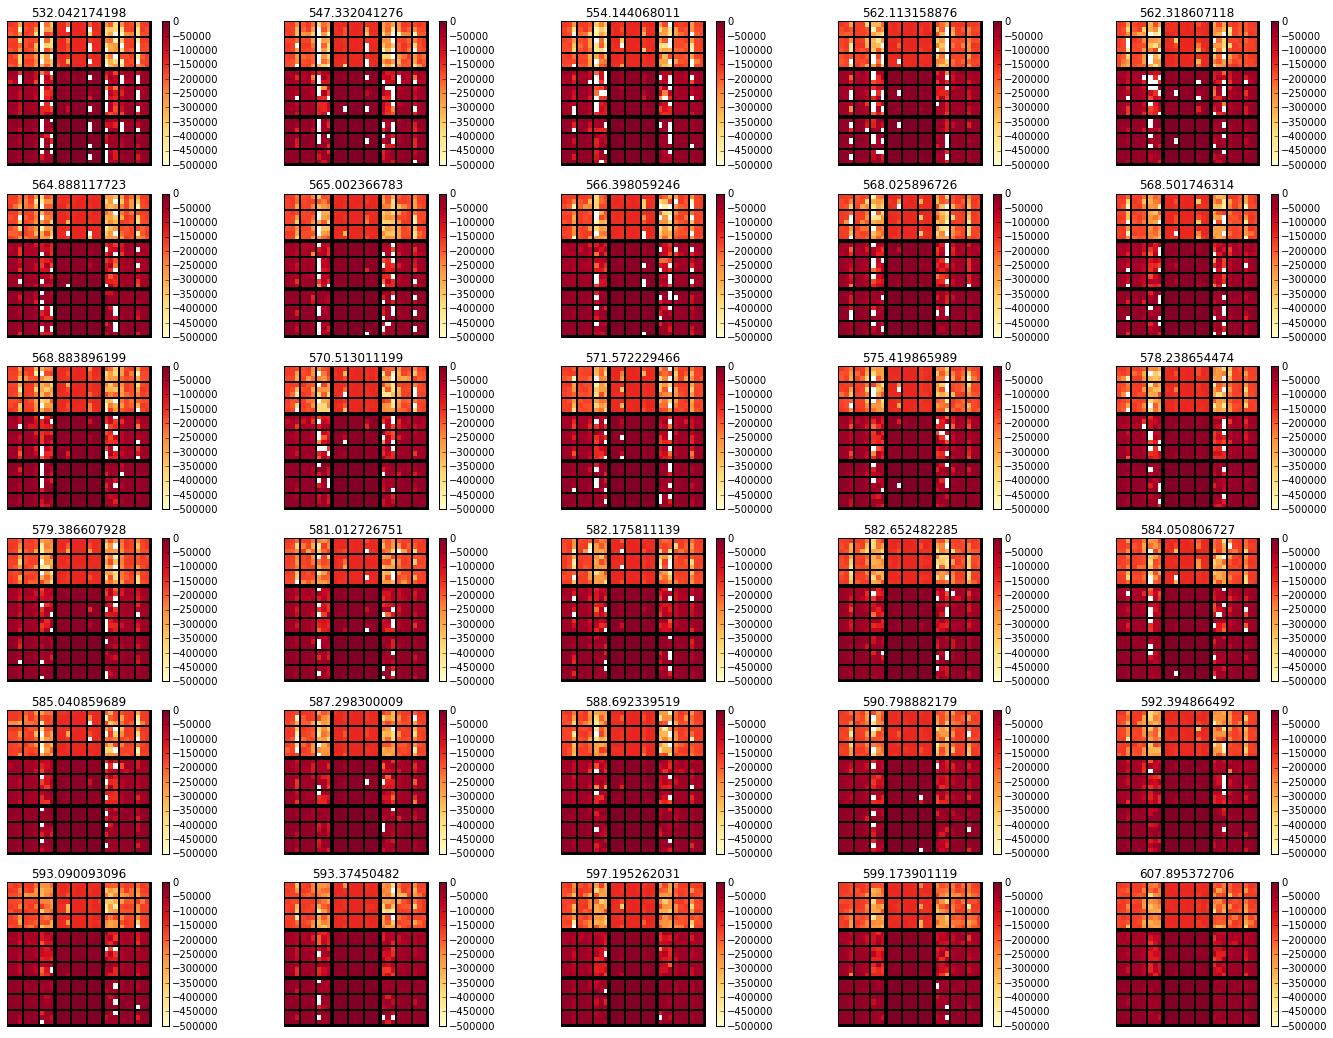

In [48]:
performance_maps = [pickle.load(open("results/viability_5_mins_"+str(seed)+"/full_trajectory_qd_map.pickle")) for seed in range(1,31)]
#performance_maps = [pickle.load(open("results/init_results/full_trajectory_5_mins_"+str(seed)+".pickle")) for seed in range(1,31)]

performance_maps.sort(key=lambda x: plot_map(make_fitness_map(x), (3,3,3,3,3,3), [[1, 3, 5], [0, 2, 4]], 
                      ax='none', bounds=(-500000,0)))

viability_qd_scores = np.zeros(30)
for i, performance_map in enumerate(performance_maps):
    viability_qd_scores[i] = plot_map(make_fitness_map(performance_map), (3,3,3,3,3,3), [[1, 3, 5], [0, 2, 4]], 
                      ax=pylab.subplot(6,5,i+1), bounds=(-500000,0) )
    

    


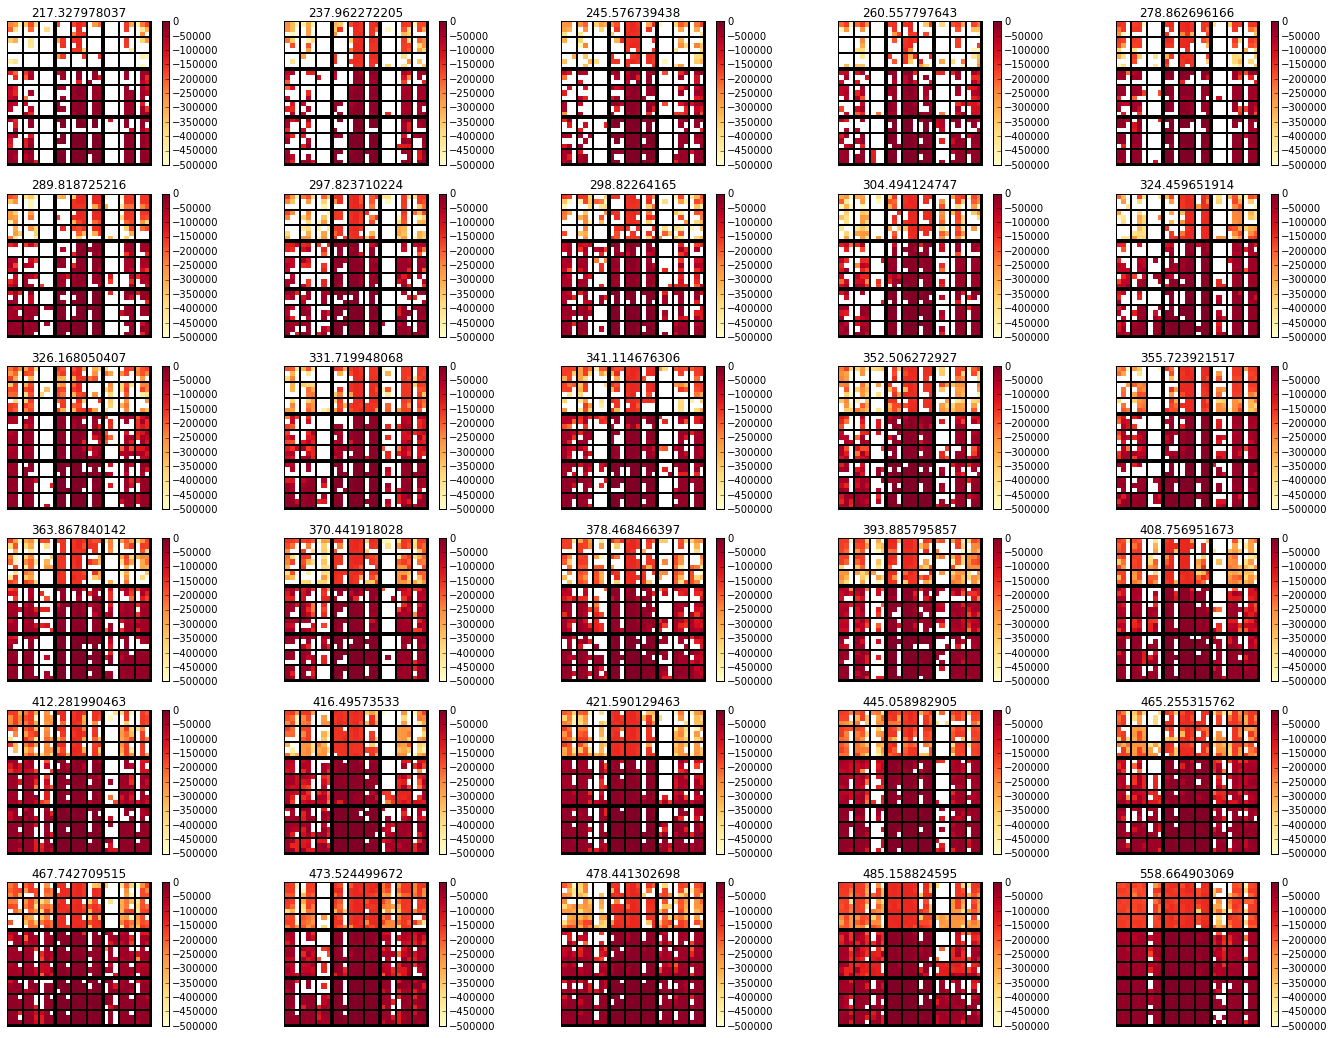

In [27]:
performance_maps = [pickle.load(open("results/fitness_5_mins_"+str(seed)+"/full_trajectory_qd_map.pickle")) for seed in range(1,31)]
#performance_maps = [pickle.load(open("results/init_results/full_trajectory_5_mins_"+str(seed)+".pickle")) for seed in range(1,31)]

performance_maps.sort(key=lambda x: plot_map(make_fitness_map(x), (3,3,3,3,3,3), [[1, 3, 5], [0, 2, 4]], 
                      ax='none', bounds=(-500000,0)))

fitness_qd_scores = np.zeros(30)
for i, performance_map in enumerate(performance_maps):
    fitness_qd_scores[i] = plot_map(make_fitness_map(performance_map), (3,3,3,3,3,3), [[1, 3, 5], [0, 2, 4]], 
                      ax=pylab.subplot(6,5,i+1), bounds=(-500000,0) )

(0, 650.0)

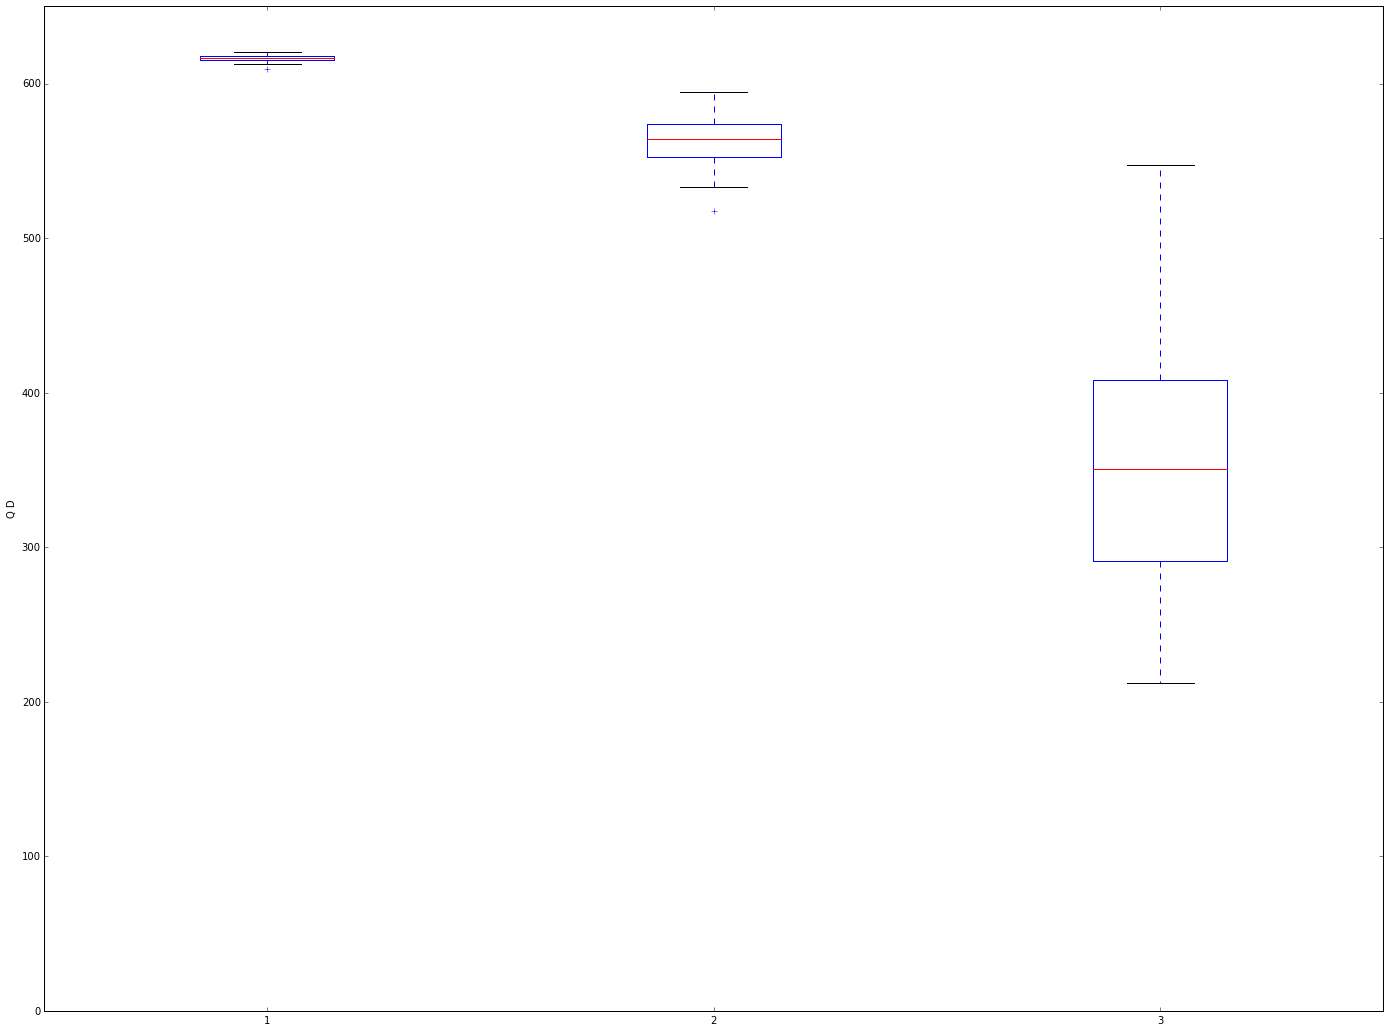

In [24]:
ax = pylab.subplot(1,1,1)
ax.hold(True)
ax.boxplot([map_elites_qd_scores, viability_qd_scores, fitness_qd_scores])
ax.set_ylabel('Q D')
ax.set_ylim(ymin=0)

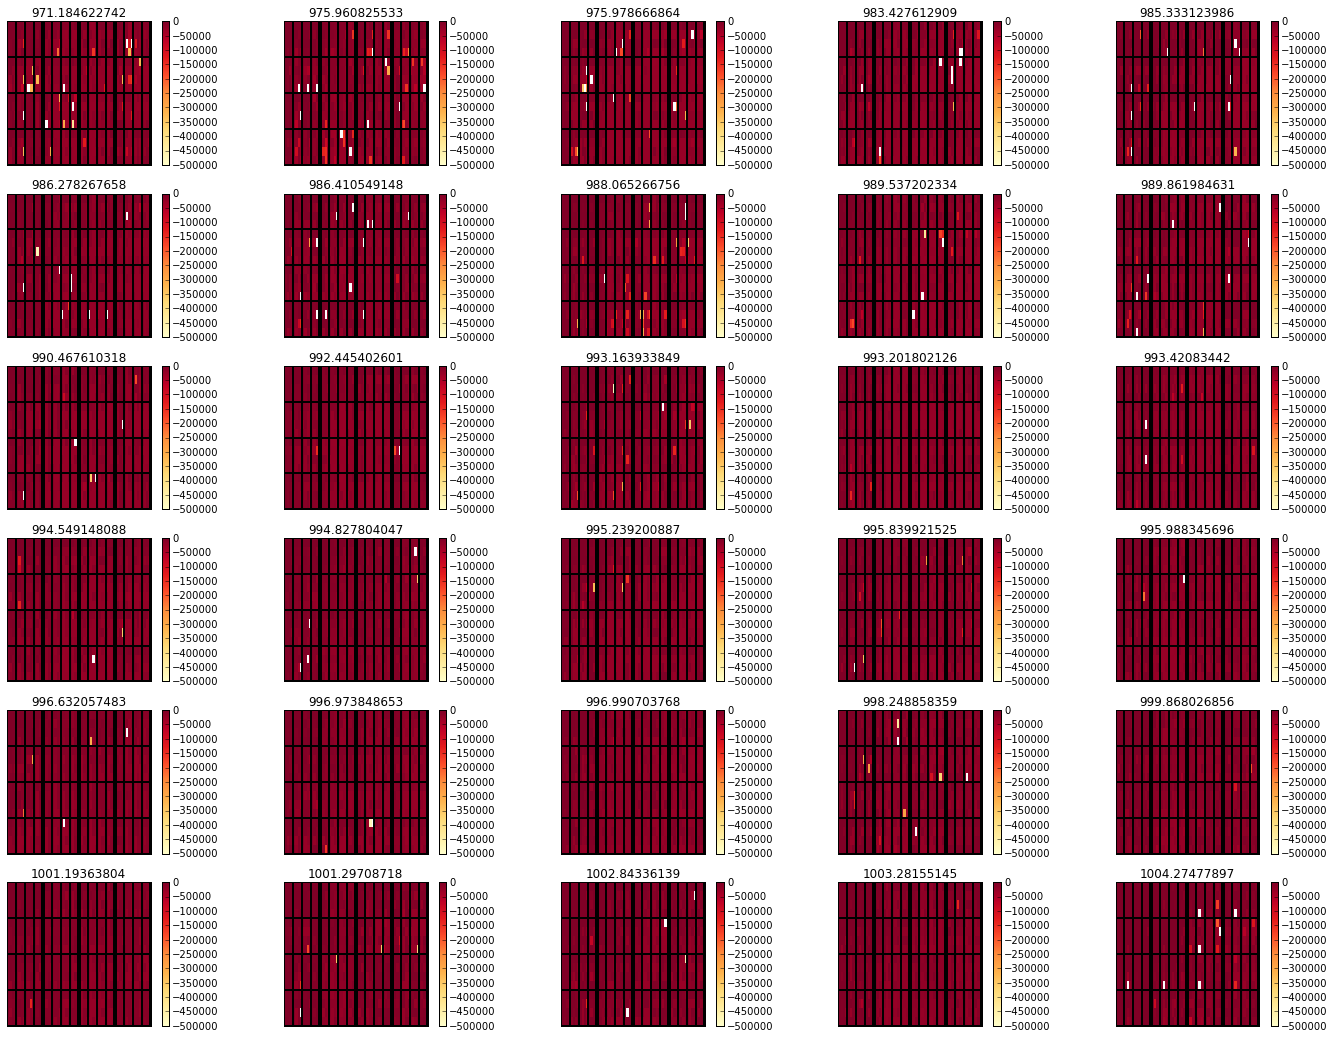

In [52]:
performance_maps = [pickle.load(open("results/direction_5_mins_"+str(seed)+"/qd_map.pickle")) for seed in range(1,31)]
#performance_maps = [pickle.load(open("results/init_results/full_trajectory_5_mins_"+str(seed)+".pickle")) for seed in range(1,31)]

performance_maps.sort(key=lambda x: plot_map(make_fitness_map(x),(4,4,4,4,4), [[1, 3], [0, 2, 4]], 
             aspect=4, ax='none', bounds=(-500000,0)))

map_elites_qd_scores = np.zeros(30)
for i, performance_map in enumerate(performance_maps):
    map_elites_qd_scores[i] = plot_map(make_fitness_map(performance_map), (4,4,4,4,4), [[1, 3], [0, 2, 4]], 
             aspect=4, ax=pylab.subplot(6,5,i+1), bounds=(-500000,0) )
    



In [53]:
playback(performance_maps[-1])

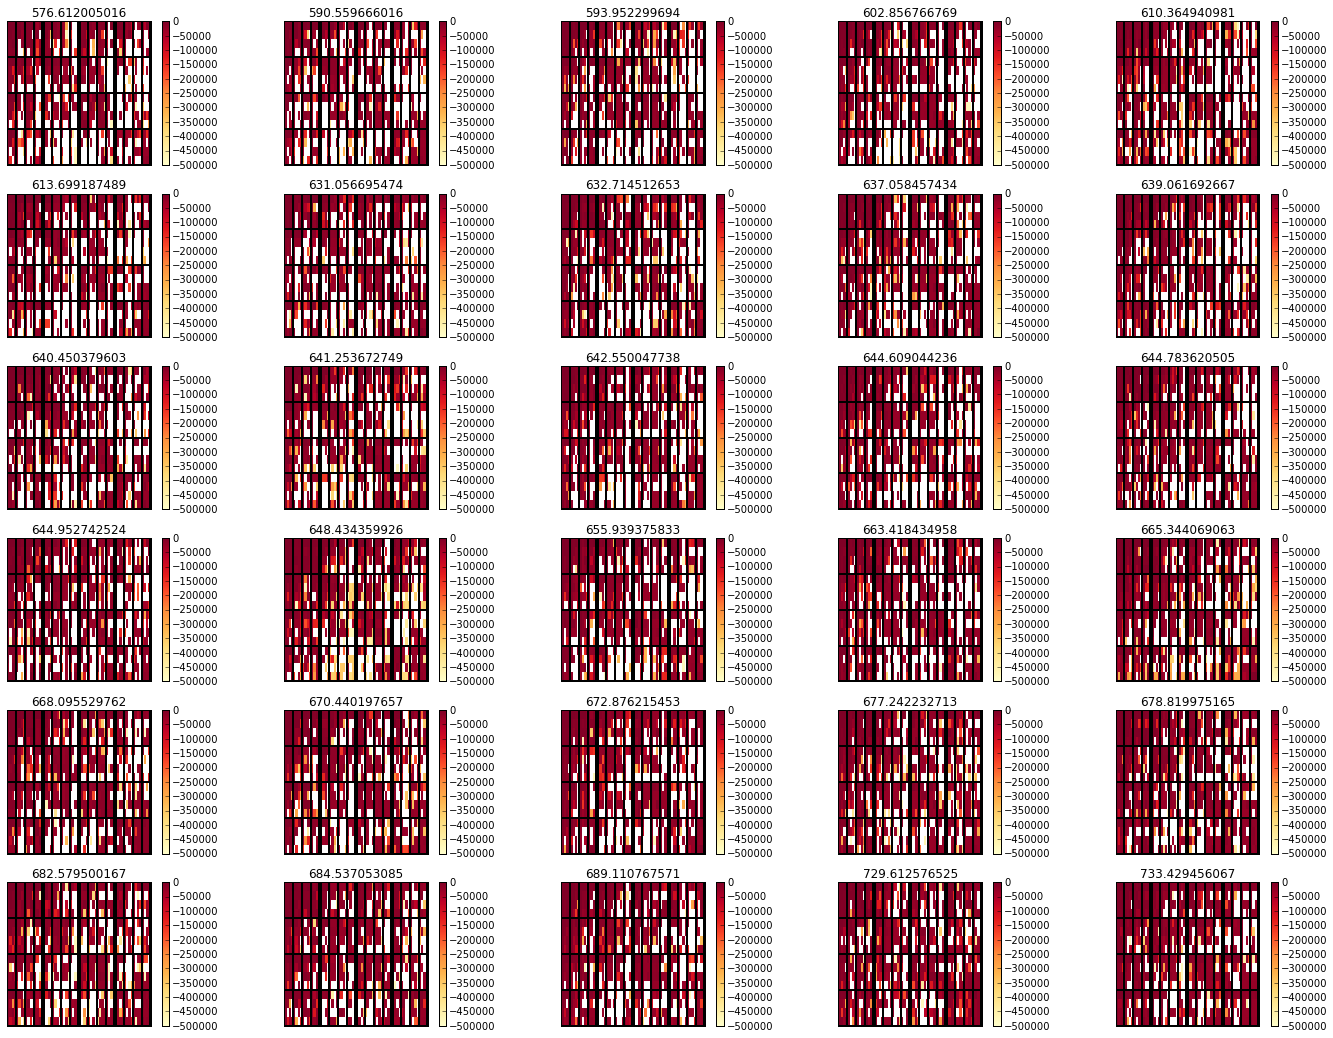

In [31]:
performance_maps = [pickle.load(open("results/viability_5_mins_"+str(seed)+"/direction_qd_map.pickle")) for seed in range(1,31)]
#performance_maps = [pickle.load(open("results/init_results/full_trajectory_5_mins_"+str(seed)+".pickle")) for seed in range(1,31)]

performance_maps.sort(key=lambda x: plot_map(make_fitness_map(x), (4,4,4,4,4), [[1, 3], [0, 2, 4]], 
             aspect=4, ax='none', bounds=(-500000,0)))

viability_qd_scores = np.zeros(30)
for i, performance_map in enumerate(performance_maps):
    viability_qd_scores[i] = plot_map(make_fitness_map(performance_map), (4,4,4,4,4), [[1, 3], [0, 2, 4]], 
             aspect=4,ax=pylab.subplot(6,5,i+1), bounds=(-500000,0) )
    


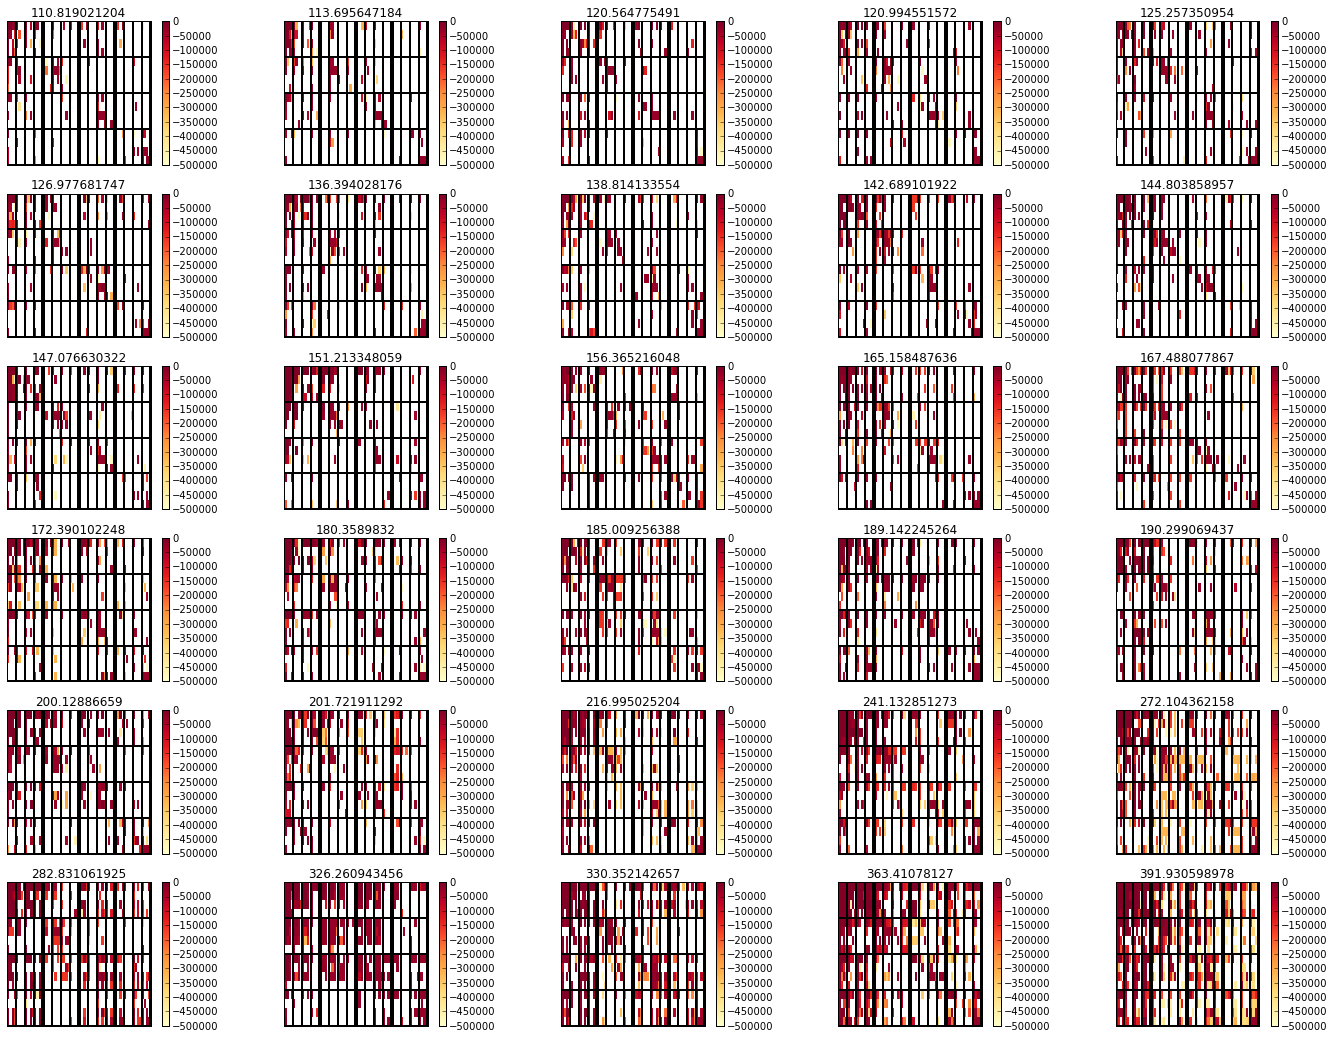

In [32]:
performance_maps = [pickle.load(open("results/fitness_5_mins_"+str(seed)+"/direction_qd_map.pickle")) for seed in range(1,31)]
#performance_maps = [pickle.load(open("results/init_results/full_trajectory_5_mins_"+str(seed)+".pickle")) for seed in range(1,31)]

performance_maps.sort(key=lambda x: plot_map(make_fitness_map(x), (4,4,4,4,4), [[1, 3], [0, 2, 4]], 
             aspect=4, ax='none', bounds=(-500000,0)))

fitness_qd_scores = np.zeros(30)
for i, performance_map in enumerate(performance_maps):
    fitness_qd_scores[i] = plot_map(make_fitness_map(performance_map), (4,4,4,4,4), [[1, 3], [0, 2, 4]], 
             aspect=4,ax=pylab.subplot(6,5,i+1), bounds=(-500000,0) )
    


(0, 1100.0)

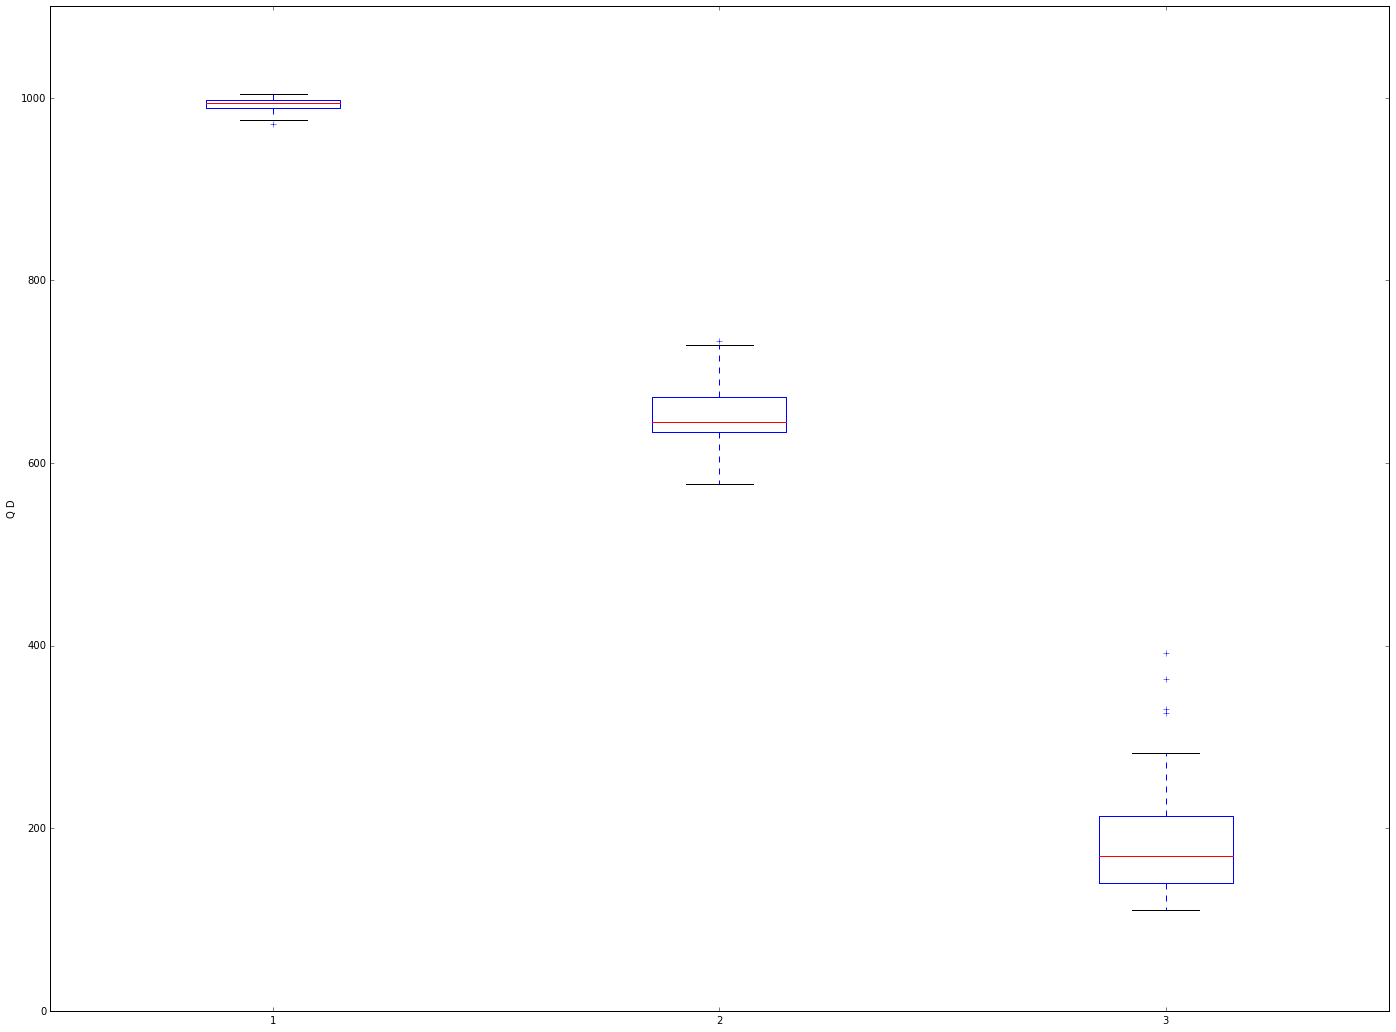

In [33]:
ax = pylab.subplot(1,1,1)
ax.hold(True)
ax.boxplot([map_elites_qd_scores, viability_qd_scores, fitness_qd_scores])
ax.set_ylabel('Q D')
ax.set_ylim(ymin=0)

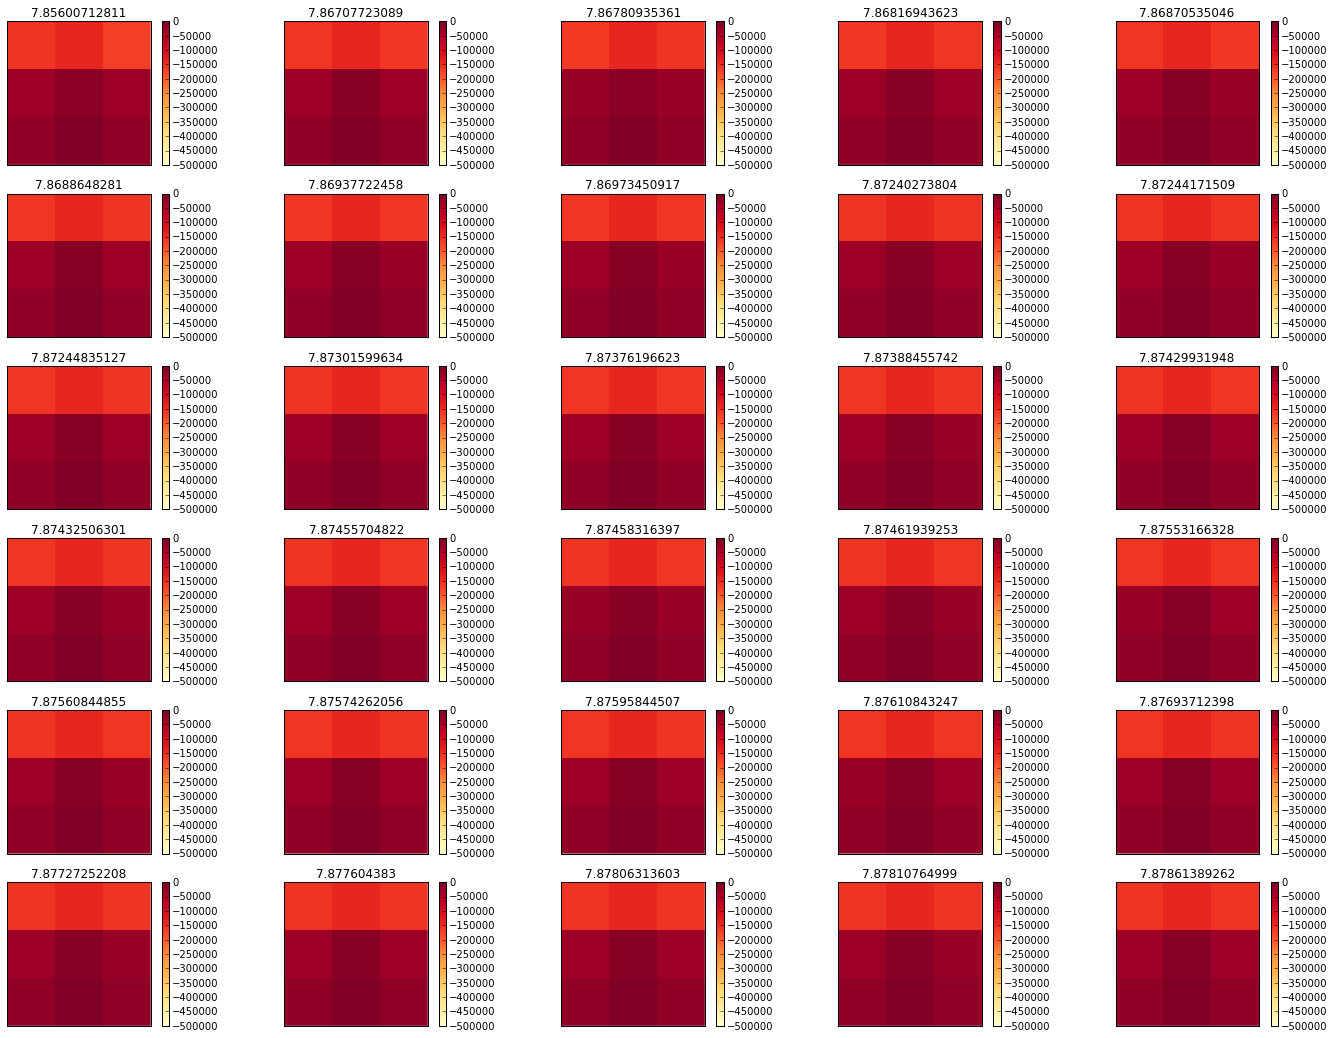

In [34]:
performance_maps = [pickle.load(open("results/endpoint_5_mins_"+str(seed)+"/qd_map.pickle")) for seed in range(1,31)]
#performance_maps = [pickle.load(open("results/init_results/full_trajectory_5_mins_"+str(seed)+".pickle")) for seed in range(1,31)]

performance_maps.sort(key=lambda x: plot_map(make_fitness_map(x), (3,3), [[1], [0]], 
                      ax='none', bounds=(-500000,0)))

map_elites_qd_scores = np.zeros(30)
for i, performance_map in enumerate(performance_maps):
    map_elites_qd_scores[i] = plot_map(make_fitness_map(performance_map), (3,3), [[1], [0]], 
                      ax=pylab.subplot(6,5,i+1), bounds=(-500000,0) )
    

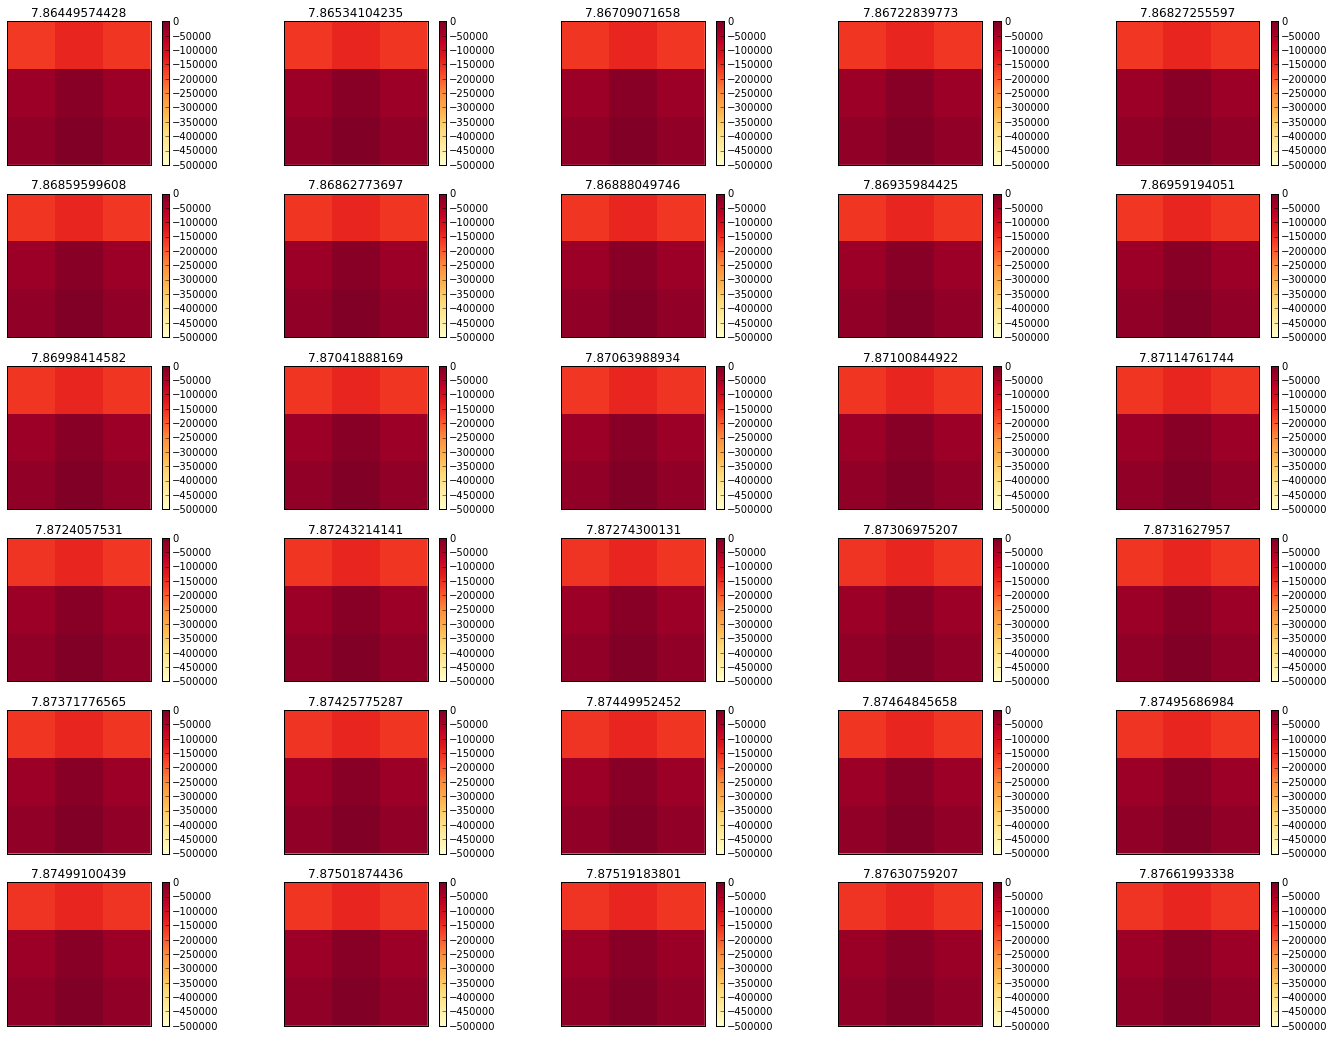

In [37]:
performance_maps = [pickle.load(open("results/viability_5_mins_"+str(seed)+"/endpoint_qd_map.pickle")) for seed in range(1,31)]
#performance_maps = [pickle.load(open("results/init_results/full_trajectory_5_mins_"+str(seed)+".pickle")) for seed in range(1,31)]

performance_maps.sort(key=lambda x: plot_map(make_fitness_map(x), (3,3), [[1], [0]], 
             ax='none', bounds=(-500000,0)))

viability_qd_scores = np.zeros(30)
for i, performance_map in enumerate(performance_maps):
    viability_qd_scores[i] = plot_map(make_fitness_map(performance_map), (3,3), [[1], [0]], 
             ax=pylab.subplot(6,5,i+1), bounds=(-500000,0) )
    


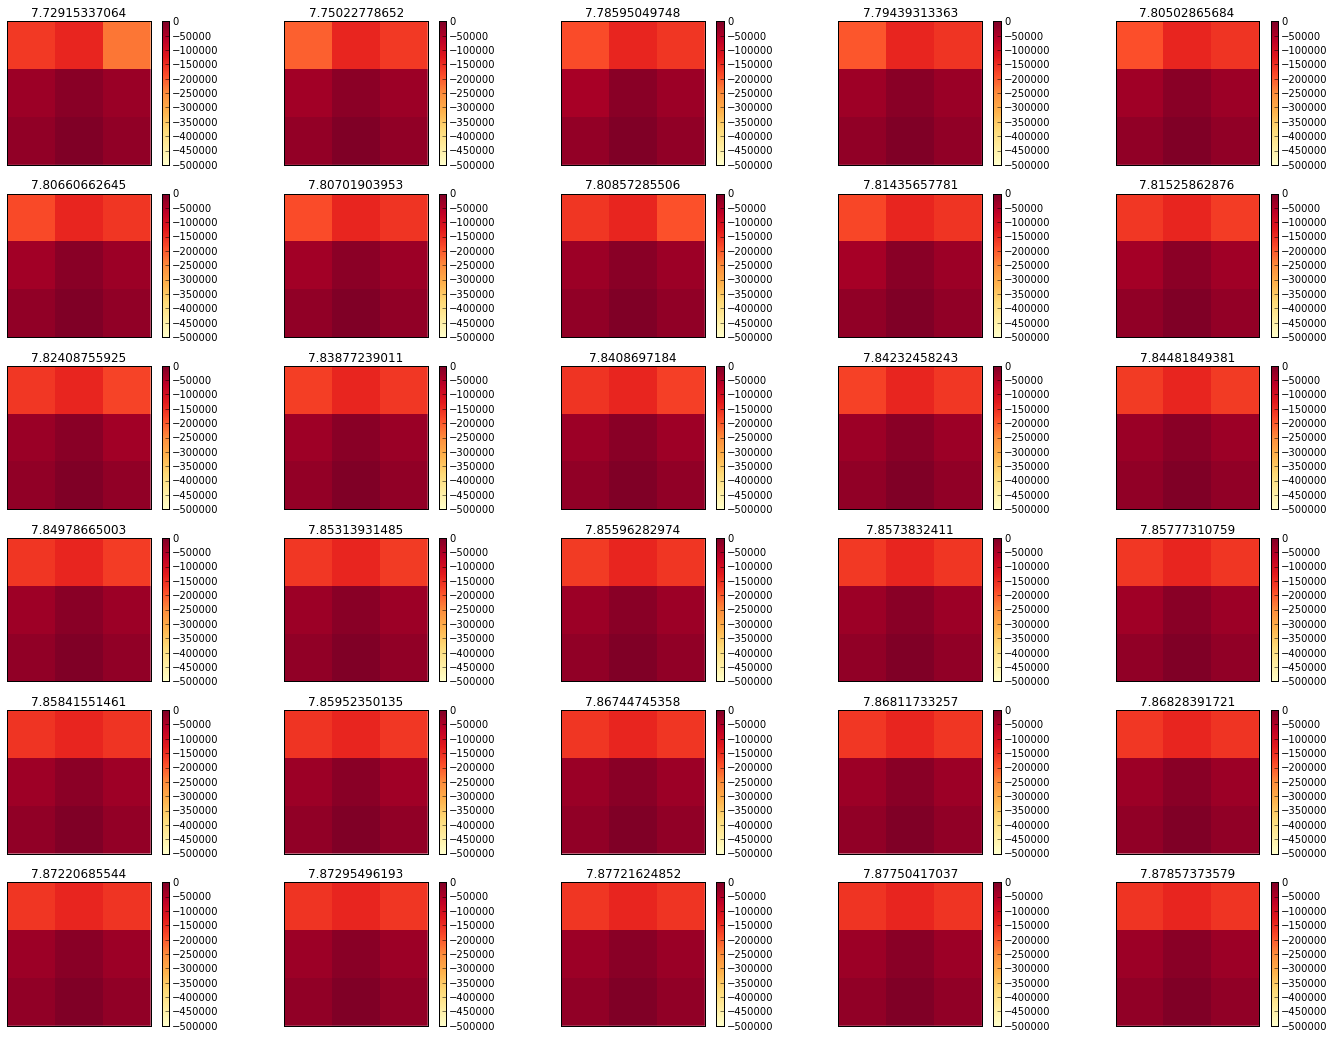

In [38]:
performance_maps = [pickle.load(open("results/fitness_5_mins_"+str(seed)+"/endpoint_qd_map.pickle")) for seed in range(1,31)]
#performance_maps = [pickle.load(open("results/init_results/full_trajectory_5_mins_"+str(seed)+".pickle")) for seed in range(1,31)]

performance_maps.sort(key=lambda x: plot_map(make_fitness_map(x), (3,3), [[1], [0]], 
             ax='none', bounds=(-500000,0)))

fitness_qd_scores = np.zeros(30)
for i, performance_map in enumerate(performance_maps):
    fitness_qd_scores[i] = plot_map(make_fitness_map(performance_map), (3,3), [[1], [0]], 
             ax=pylab.subplot(6,5,i+1), bounds=(-500000,0) )
    


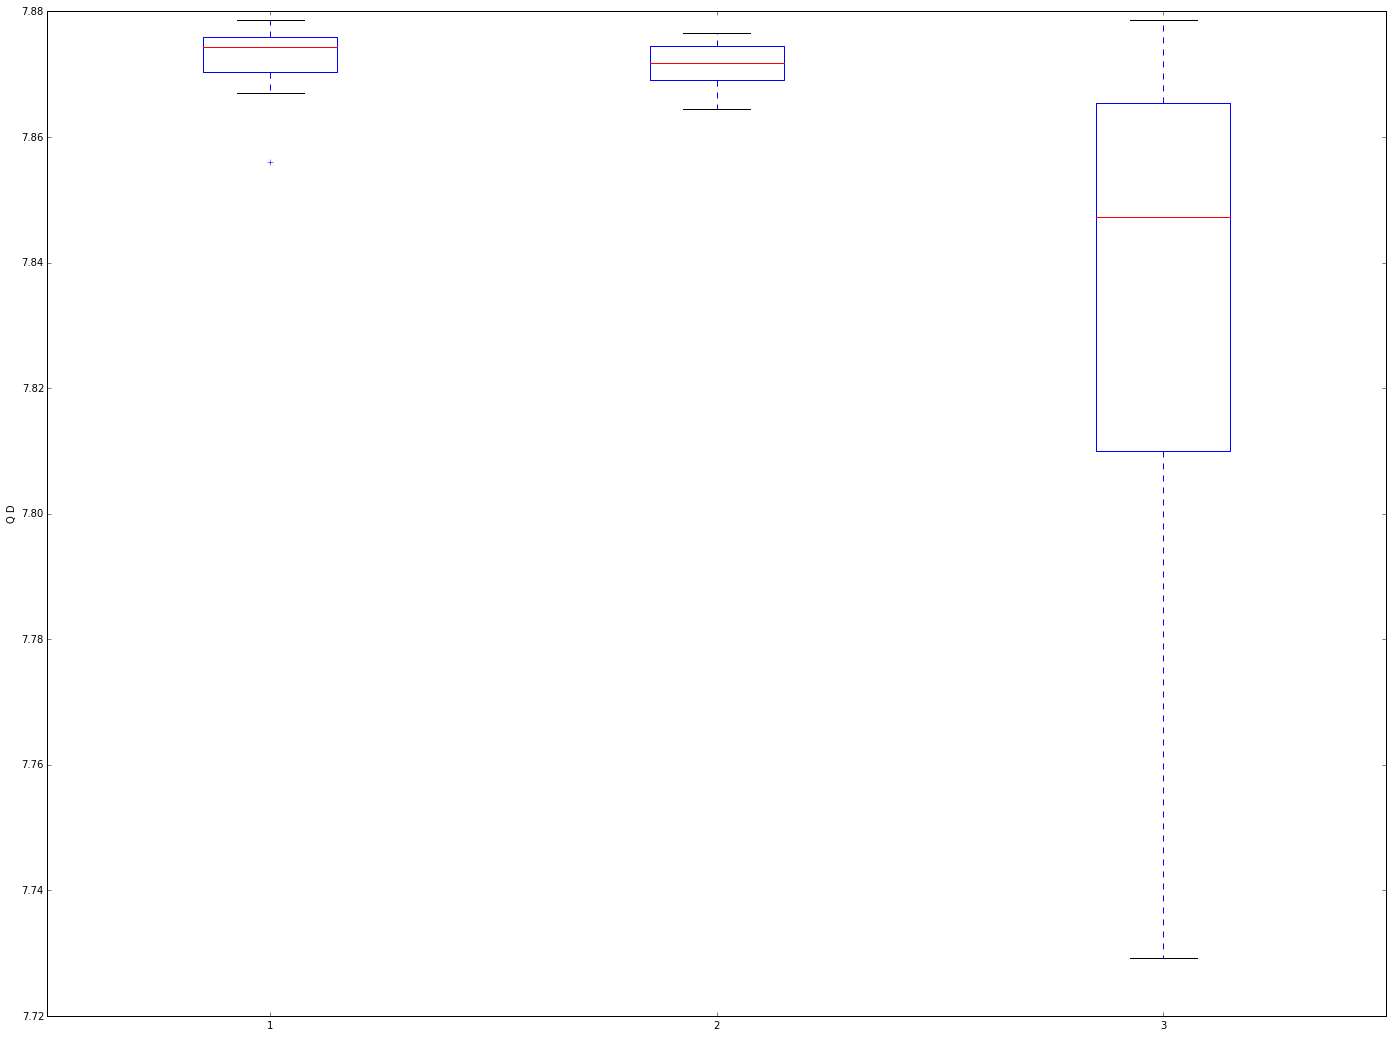

In [40]:
ax = pylab.subplot(1,1,1)
ax.hold(True)
ax.boxplot([map_elites_qd_scores, viability_qd_scores, fitness_qd_scores])
ax.set_ylabel('Q D')

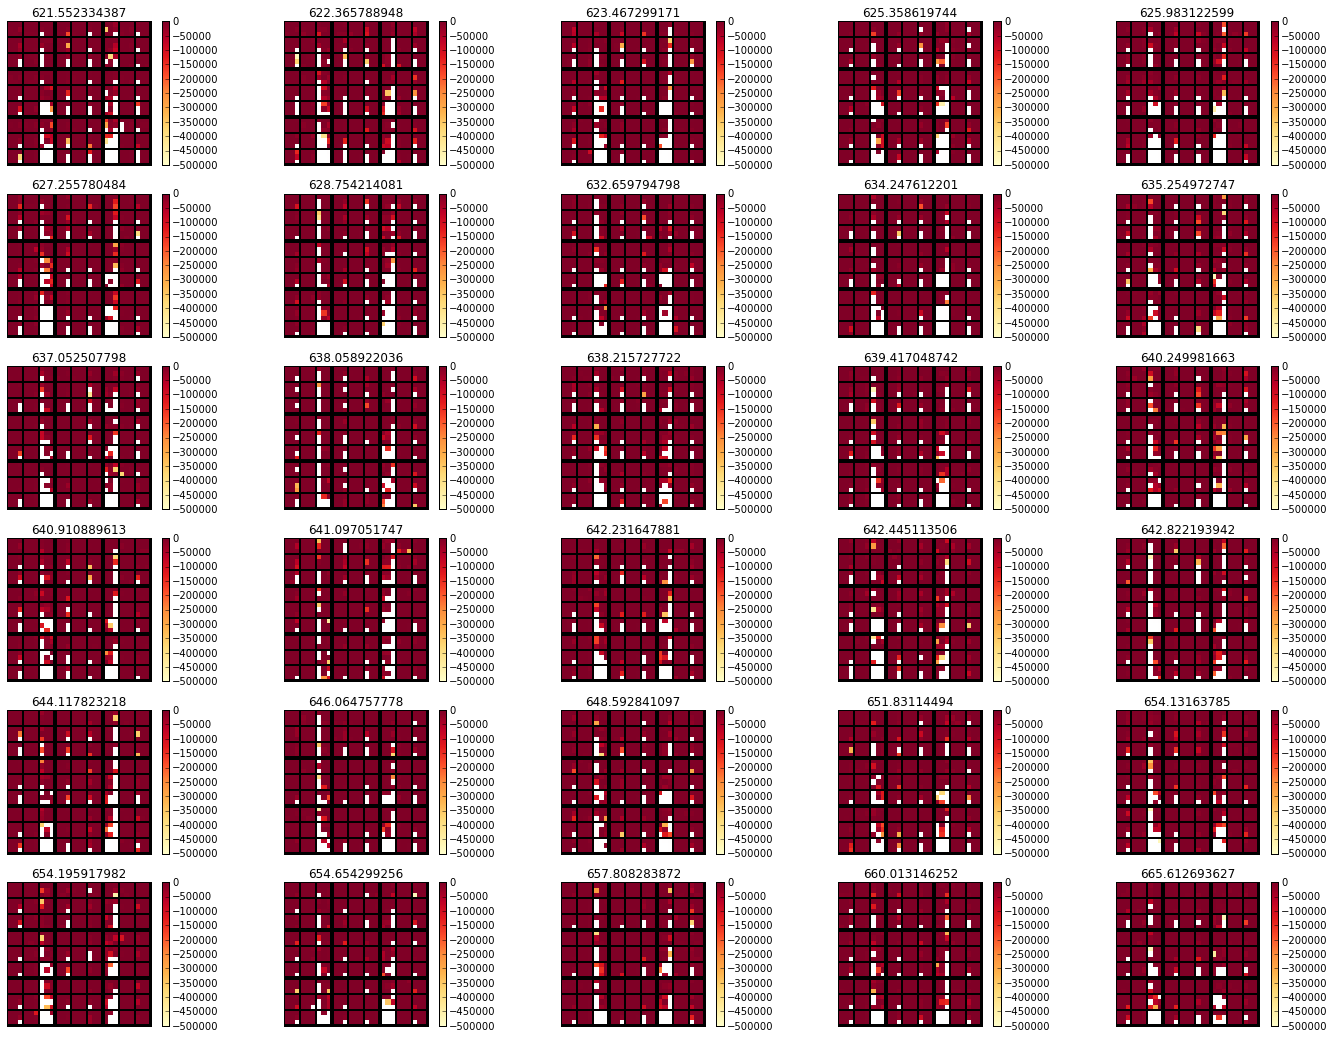

In [41]:
performance_maps = [pickle.load(open("results/half_trajectory_5_mins_"+str(seed)+"/qd_map.pickle")) for seed in range(1,31)]
#performance_maps = [pickle.load(open("results/init_results/full_trajectory_5_mins_"+str(seed)+".pickle")) for seed in range(1,31)]

performance_maps.sort(key=lambda x: plot_map(make_fitness_map(x), (3,3,3,3,3,3), [[1, 3, 5], [0, 2, 4]], 
                      ax='none', bounds=(-500000,0)))

map_elites_qd_scores = np.zeros(30)
for i, performance_map in enumerate(performance_maps):
    map_elites_qd_scores[i] = plot_map(make_fitness_map(performance_map), (3,3,3,3,3,3), [[1, 3, 5], [0, 2, 4]], 
                      ax=pylab.subplot(6,5,i+1), bounds=(-500000,0) )
    

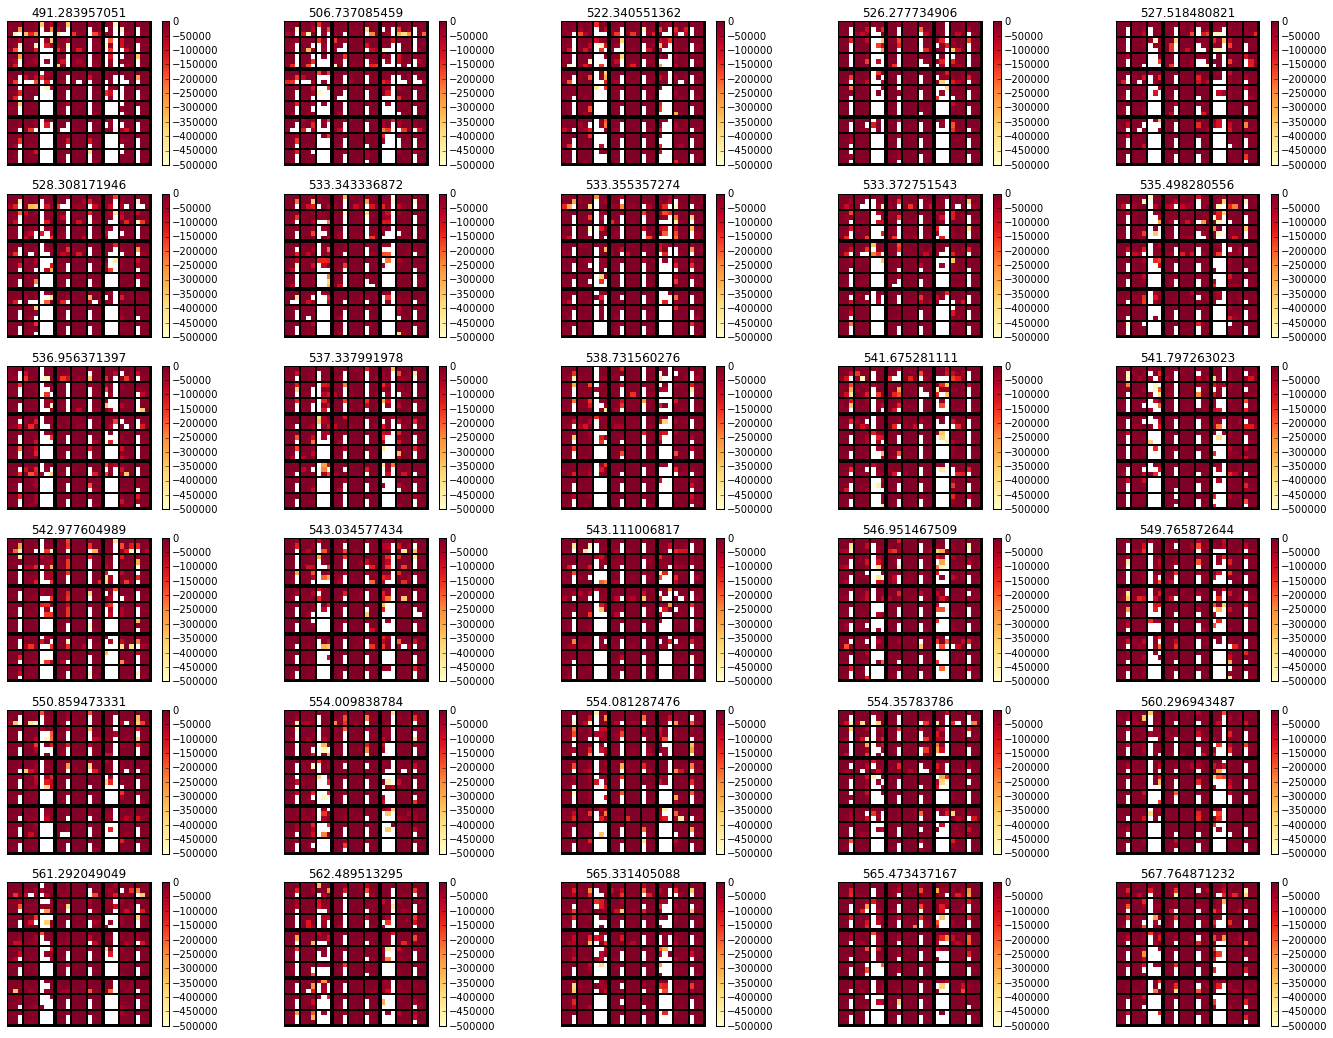

In [42]:
performance_maps = [pickle.load(open("results/viability_5_mins_"+str(seed)+"/half_trajectory_qd_map.pickle")) for seed in range(1,31)]
#performance_maps = [pickle.load(open("results/init_results/full_trajectory_5_mins_"+str(seed)+".pickle")) for seed in range(1,31)]

performance_maps.sort(key=lambda x: plot_map(make_fitness_map(x), (3,3,3,3,3,3), [[1, 3, 5], [0, 2, 4]], 
                      ax='none', bounds=(-500000,0)))

viability_qd_scores = np.zeros(30)
for i, performance_map in enumerate(performance_maps):
    viability_qd_scores[i] = plot_map(make_fitness_map(performance_map), (3,3,3,3,3,3), [[1, 3, 5], [0, 2, 4]], 
                      ax=pylab.subplot(6,5,i+1), bounds=(-500000,0) )



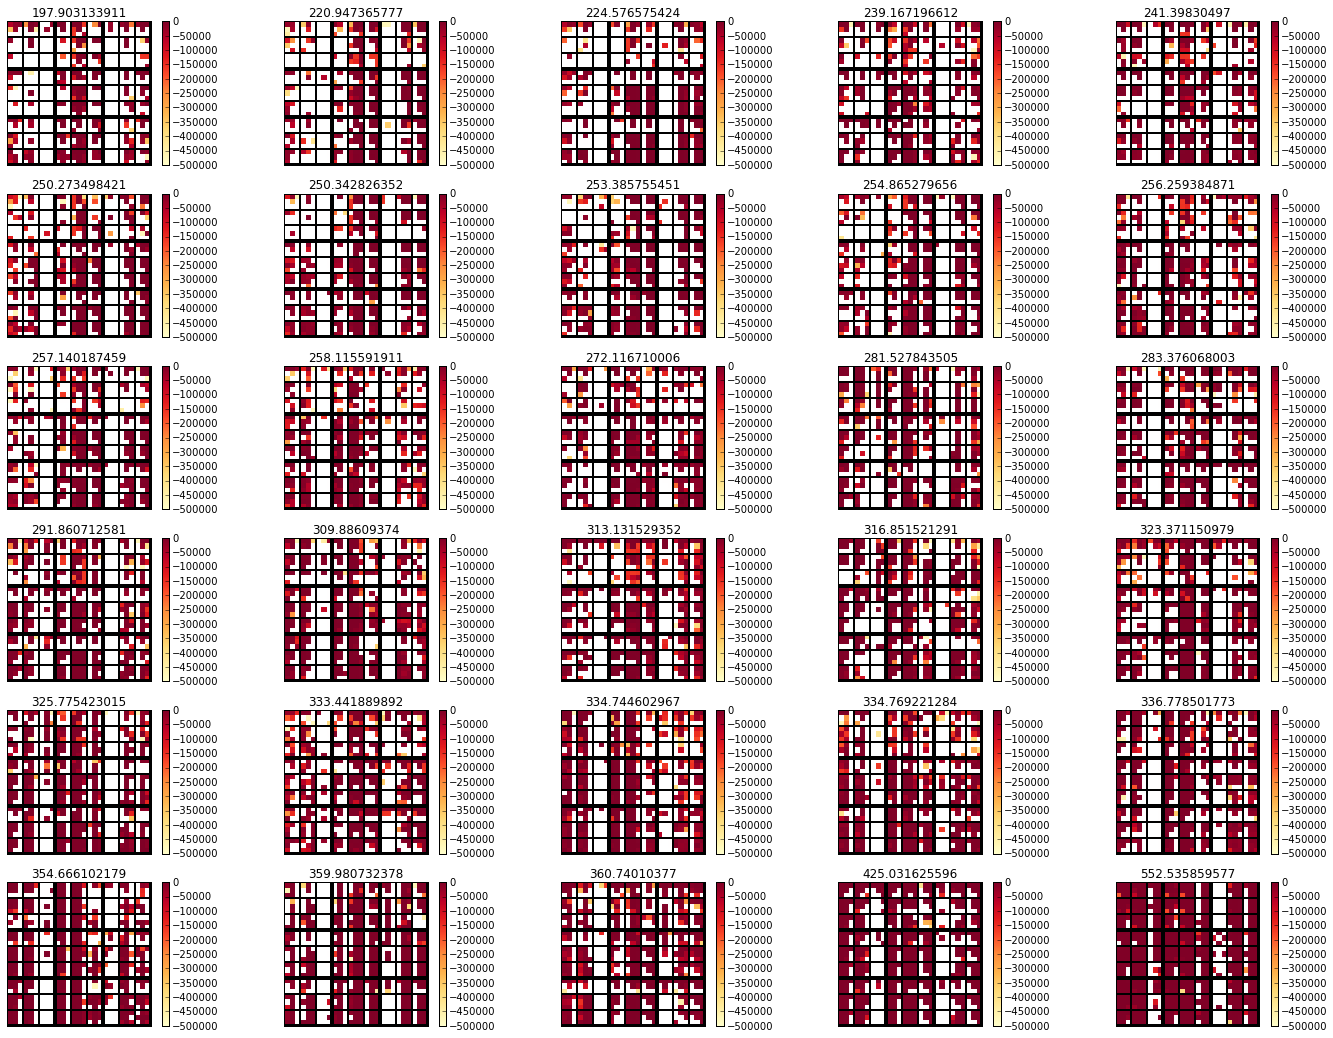

In [43]:
performance_maps = [pickle.load(open("results/fitness_5_mins_"+str(seed)+"/half_trajectory_qd_map.pickle")) for seed in range(1,31)]
#performance_maps = [pickle.load(open("results/init_results/full_trajectory_5_mins_"+str(seed)+".pickle")) for seed in range(1,31)]

performance_maps.sort(key=lambda x: plot_map(make_fitness_map(x), (3,3,3,3,3,3), [[1, 3, 5], [0, 2, 4]], 
                      ax='none', bounds=(-500000,0)))

fitness_qd_scores = np.zeros(30)
for i, performance_map in enumerate(performance_maps):
    fitness_qd_scores[i] = plot_map(make_fitness_map(performance_map), (3,3,3,3,3,3), [[1, 3, 5], [0, 2, 4]], 
                      ax=pylab.subplot(6,5,i+1), bounds=(-500000,0) )
    


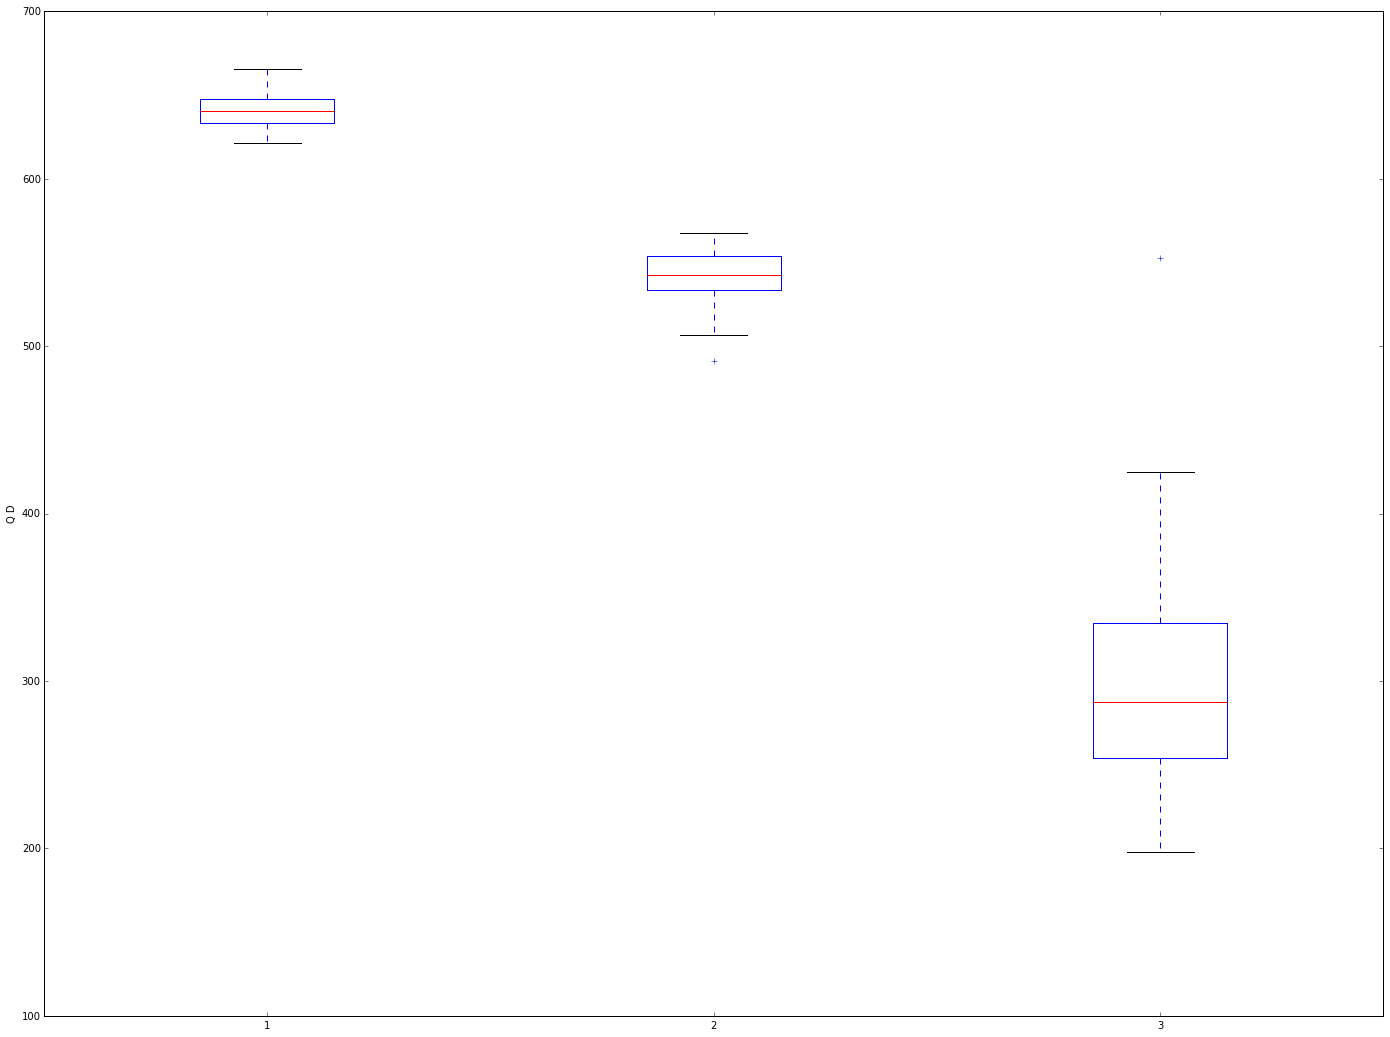

In [44]:
ax = pylab.subplot(1,1,1)
ax.hold(True)
ax.boxplot([map_elites_qd_scores, viability_qd_scores, fitness_qd_scores])
ax.set_ylabel('Q D')

0

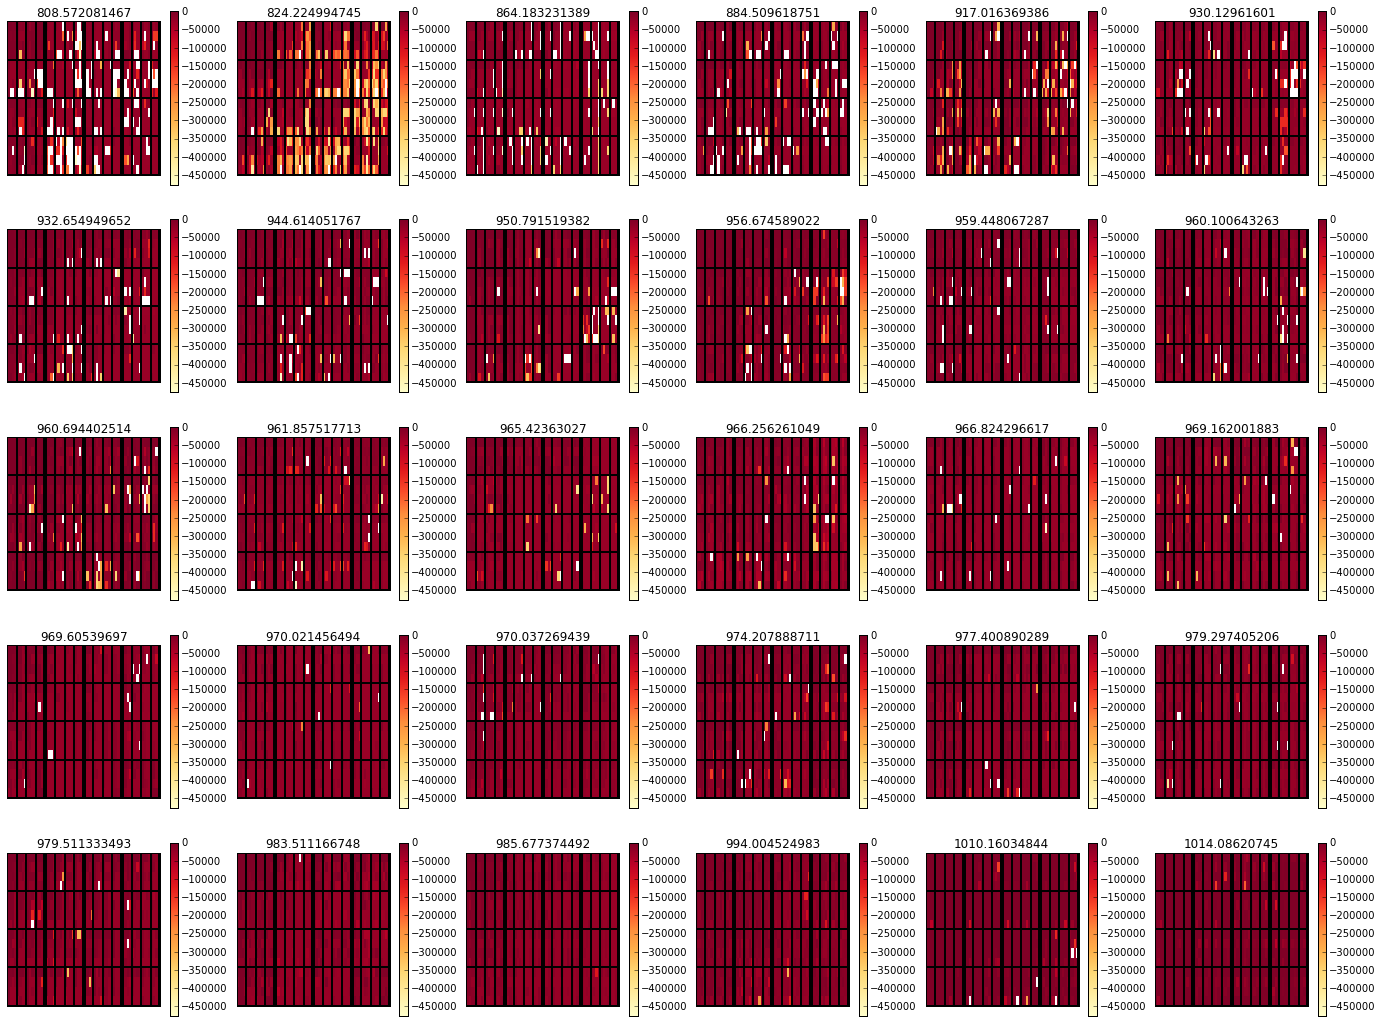

In [127]:
performance_maps = [pickle.load(open("results/direction_5_mins_"+str(seed)+".pickle")) for seed in range(1,31)]

min_global_fitness = 0
max_global_fitness = 0
for i, performance_map in enumerate(performance_maps) :
    min_fitness = np.min([-1 * performance_map[key][0].fitness for key in performance_map])
    max_fitness = np.max([-1 * performance_map[key][0].fitness for key in performance_map])
    if i == 0 or min_fitness < min_global_fitness :
        min_global_fitness = min_fitness
    if i == 0 or max_fitness > max_global_fitness :
        max_global_fitness = max_fitness


performance_maps.sort(key = lambda performance_map: plot_map(make_fitness_map(performance_map), (4,4,4,4,4), [[1, 3], [0, 2, 4]], 
                                                             aspect=4, ax='none',
                                                             bounds=(min_global_fitness,max_global_fitness)))
        
        
for i, performance_map in enumerate(performance_maps) :
    plot_map(make_fitness_map(performance_map), (4,4,4,4,4), [[1, 3], [0, 2, 4]], 
             aspect=4, ax=pylab.subplot(5,6,i+1),
             bounds=(min_global_fitness,max_global_fitness))
    

    

In [4]:
min_key = min(performance_map, key=lambda x : performance_map[x][0].fitness)
print performance_map[min_key][0].fitness
np.savetxt('best_robot.txt',performance_map[max_key][0].genome[None,:])

0.41873


NameError: name 'max_key' is not defined

In [37]:
fitnesses = [ performance_map[key][0].fitness for key in performance_map]
fitnesses.sort()
fitnesses[:10]

[0.10581599999999999,
 0.17288999999999999,
 0.242257,
 1.0478989999999999,
 1.3340879999999999,
 1.6361699999999999,
 2.0980490000000001,
 2.119545,
 2.3737759999999999,
 3.074837]

In [71]:
performance_maps = [pickle.load(open("direction_5_mins_" + str(i) + ".pickle")) for i in range(1,3)]

keys = list(set(reduce(lambda x,y: x.keys()+y.keys(), performance_maps)))

performance_map = {}

for key in keys :
    performance_map[key] = []
    for pm in performance_maps :
        if key in pm :
            performance_map[key].append(pm[key][0].fitness)

#print performance_map            
            

71.19691004531025

320.55623397778896

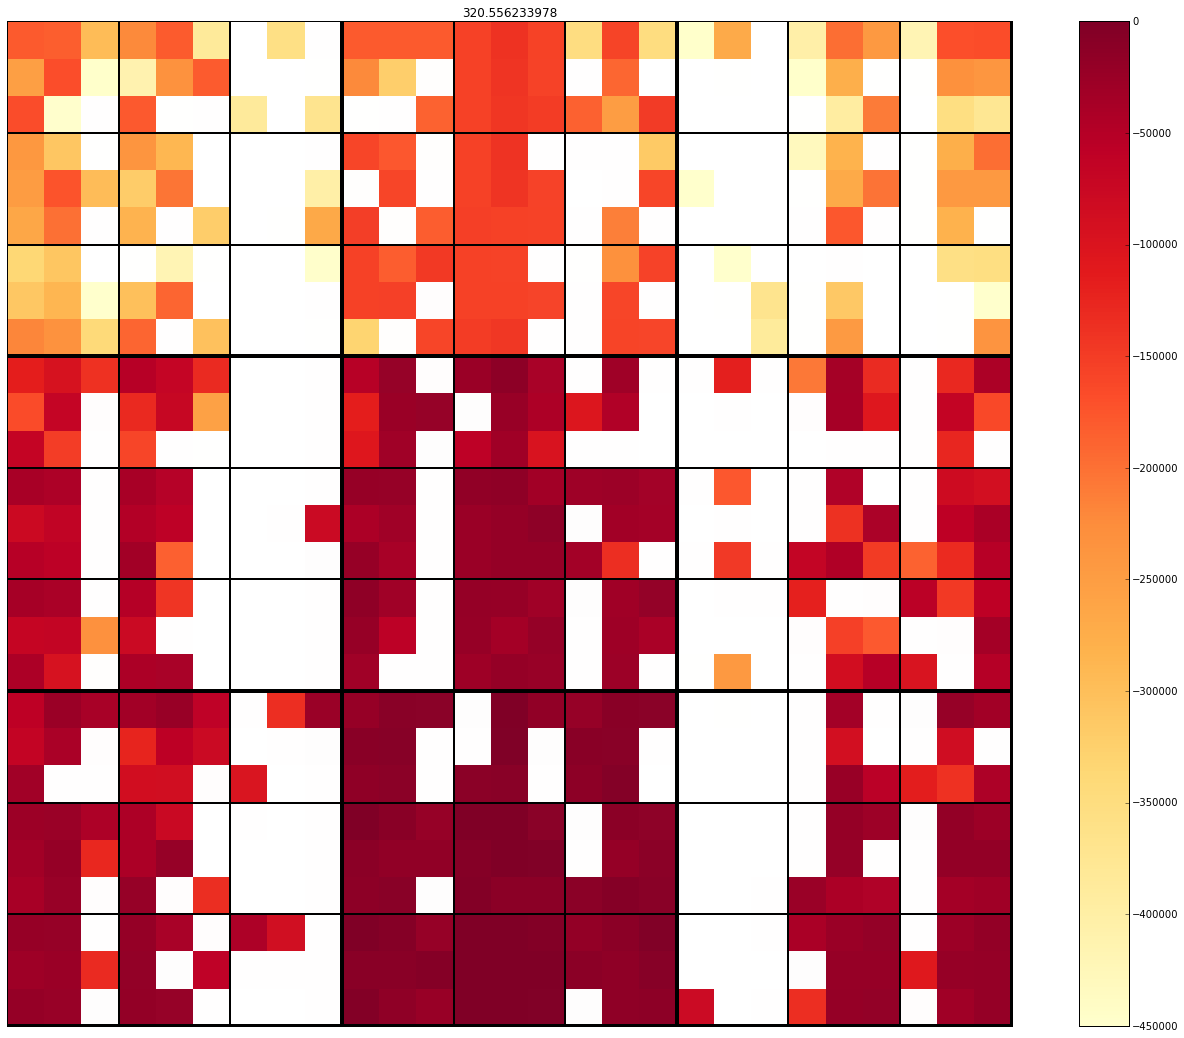

In [133]:
performance_map = pickle.load(open("viability_5_mins_1/filtered_map_full_trajectory.pickle","r"))

fitness_map = {key : performance_map[key].fitness for key in performance_map}

plot_map(fitness_map, (3,3,3,3,3,3), [[1, 3, 5], [0, 2, 4]], 
             ax=pylab.subplot(1,1,1),  bounds=(-450000,0))
